# 02 — Supervised Learning Models

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
from pathlib import Path

Path("/content/drive/MyDrive/Student-Stress-Academic-Performance/models").mkdir(exist_ok=True)
print("Folders ready: models/, outputs/")


Folders ready: models/, outputs/


In [153]:
# ============================================================
# Setup: Load processed dataset created in 01_Design_EDA.ipynb
# ============================================================

import os
import pandas as pd
import numpy as np

PROCESSED_DATA_PATH = "/content/drive/MyDrive/Student-Stress-Academic-Performance/processed_student_mental_health.csv"

if not os.path.exists(PROCESSED_DATA_PATH):
    raise FileNotFoundError(
        f"Processed file not found: {PROCESSED_DATA_PATH}. "
        "Please run 01_Design_EDA.ipynb first."
    )

df = pd.read_csv(PROCESSED_DATA_PATH)
df.head()


,Timestamp,Choose your gender,Age,What is your course?,Your current year of Study,What is your CGPA?,Marital status,Do you have Depression?,Do you have Anxiety?,Do you have Panic attack?,Did you seek any specialist for a treatment?,depression_bin,anxiety_bin,panic_bin,treatment_bin,stress_score,high_stress_no_treatment,high_cgpa,cgpa_clean
0,8/7/2020 12:02,Female,18.0,Engineering,year 1,3.00-3.49,No,Yes,No,Yes,No,1,0,1,0,2,1,0,3.00-3.49
1,8/7/2020 12:04,Male,21.0,Islamic education,year 2,3.00-3.49,No,No,Yes,No,No,0,1,0,0,1,0,0,3.00-3.49
2,8/7/2020 12:05,Male,19.0,BIT,Year 1,3.00-3.49,No,Yes,Yes,Yes,No,1,1,1,0,3,1,0,3.00-3.49
3,8/7/2020 12:06,Female,22.0,Laws,year 3,3.00-3.49,Yes,Yes,No,No,No,1,0,0,0,1,0,0,3.00-3.49
4,8/7/2020 12:13,Male,23.0,Mathemathics,year 4,3.00-3.49,No,No,No,No,No,0,0,0,0,0,0,0,3.00-3.49


In [154]:
# ============================================================
# BLOK 10.0: NaN CHECK BEFORE MODELING
# Amaç:
# - Logistic Regression hatasının sebebi olan NaN değerlerinin
#   hangi feature(lar)dan geldiğini tespit etmek
# ============================================================

features = ["Age", "stress_score", "depression_bin", "anxiety_bin", "panic_bin"]

print("NaN counts in features:")
print(df[features].isna().sum())

print("\nRows with NaN in any feature (first 10):")
display(df[df[features].isna().any(axis=1)][features].head(10))


NaN counts in features:
Age               0
stress_score      0
depression_bin    0
anxiety_bin       0
panic_bin         0
dtype: int64

Rows with NaN in any feature (first 10):


,Age,stress_score,depression_bin,anxiety_bin,panic_bin


In [155]:
# ============================================================
# BLOK 10.0: NaN CHECK BEFORE MODELING
# Amaç:
# - Logistic Regression hatasının sebebi olan NaN değerlerinin
#   hangi feature(lar)dan geldiğini tespit etmek
# ============================================================

features = ["Age", "stress_score", "depression_bin", "anxiety_bin", "panic_bin"]

print("NaN counts in features:")
print(df[features].isna().sum())

print("\nRows with NaN in any feature (first 10):")
display(df[df[features].isna().any(axis=1)][features].head(10))


NaN counts in features:
Age               0
stress_score      0
depression_bin    0
anxiety_bin       0
panic_bin         0
dtype: int64

Rows with NaN in any feature (first 10):


,Age,stress_score,depression_bin,anxiety_bin,panic_bin


In [156]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/Student-Stress-Academic-Performance/processed_student_mental_health.csv")

feature_cols = ["Age", "stress_score", "depression_bin", "anxiety_bin", "panic_bin"]
X = df[feature_cols]
y = df["high_cgpa"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (80, 5) Test shape: (21, 5)


=== Logistic Regression Results ===
Accuracy : 0.6667
Precision: 0.8000
Recall   : 0.4000
F1-score : 0.5333

Confusion Matrix:
[[10  1]
 [ 6  4]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6250    0.9091    0.7407        11
           1     0.8000    0.4000    0.5333        10

    accuracy                         0.6667        21
   macro avg     0.7125    0.6545    0.6370        21
weighted avg     0.7083    0.6667    0.6420        21



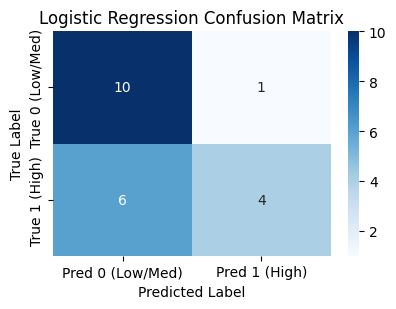

In [157]:
# ============================================================
# BLOK 10.2: LOGISTIC REGRESSION PIPELINE (WITH IMPUTER)
# Amaç:
# - Eksik değerleri pipeline içinde tamamlamak (imputation)
# - Ölçekleme (standardization) uygulamak
# - Logistic Regression ile high_cgpa tahmini yapmak
# - Metrikleri ve Confusion Matrix'i raporlanabilir şekilde üretmek
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# ------------------------------------------------------------
# 1) Feature set ve target
# ------------------------------------------------------------
feature_cols = ["Age", "stress_score", "depression_bin", "anxiety_bin", "panic_bin"]
X = df[feature_cols]
y = df["high_cgpa"]

# ------------------------------------------------------------
# 2) Train/Test split (stratified)
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# ------------------------------------------------------------
# 3) Pipeline: imputer -> scaler -> logistic regression
# ------------------------------------------------------------
logreg_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

# ------------------------------------------------------------
# 4) Model eğitimi ve tahmin
# ------------------------------------------------------------
logreg_pipeline.fit(X_train, y_train)
y_pred = logreg_pipeline.predict(X_test)

# ------------------------------------------------------------
# 5) Metrikler (pos_label=1 => High CGPA sınıfı)
# ------------------------------------------------------------
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label=1)
rec = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("=== Logistic Regression Results ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ------------------------------------------------------------
# 6) Confusion Matrix Heatmap (görselleştirme)
# ------------------------------------------------------------
save_fig = False  # True yaparsan dosyaya kaydeder
fig_path = "figures/fig_logreg_confusion_matrix.png"

plt.figure(figsize=(4.2, 3.2))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0 (Low/Med)", "Pred 1 (High)"],
    yticklabels=["True 0 (Low/Med)", "True 1 (High)"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic Regression Confusion Matrix")
plt.tight_layout()

if save_fig:
    plt.savefig(fig_path, dpi=300)

plt.show()


=== Decision Tree Results ===
Accuracy : 0.5238
Precision: 0.5000
Recall   : 0.5000
F1-score : 0.5000

Confusion Matrix:
[[6 5]
 [5 5]]

Classification Report:
              precision    recall  f1-score   support

           0     0.5455    0.5455    0.5455        11
           1     0.5000    0.5000    0.5000        10

    accuracy                         0.5238        21
   macro avg     0.5227    0.5227    0.5227        21
weighted avg     0.5238    0.5238    0.5238        21



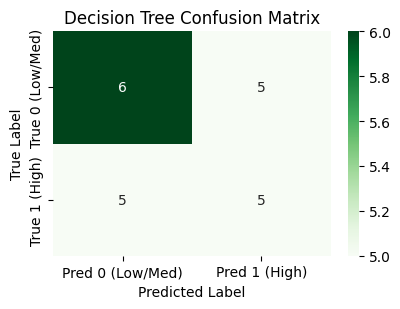

In [158]:
# ============================================================
# BLOK 11: DECISION TREE CLASSIFIER
# Amaç:
# - Decision Tree ile high_cgpa tahmini yapmak
# - Metrikleri ve Confusion Matrix'i raporlanabilir şekilde üretmek
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# ------------------------------------------------------------
# 1) Feature set ve target (aynı feature set ile adil karşılaştırma)
# ------------------------------------------------------------
feature_cols = ["Age", "stress_score", "depression_bin", "anxiety_bin", "panic_bin"]
X = df[feature_cols]
y = df["high_cgpa"]

# ------------------------------------------------------------
# 2) Train/Test split (stratified)
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# ------------------------------------------------------------
# 3) Pipeline: imputer -> decisiontree
# (Decision Tree ölçekleme istemez, scaler eklemiyoruz.)
# ------------------------------------------------------------
dt_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("dt", DecisionTreeClassifier(
        max_depth=3,          # overfitting azaltmak için
        random_state=42
    ))
])

# ------------------------------------------------------------
# 4) Model eğitimi ve tahmin
# ------------------------------------------------------------
dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)

# ------------------------------------------------------------
# 5) Metrikler (pos_label=1 => High CGPA sınıfı)
# ------------------------------------------------------------
acc = accuracy_score(y_test, y_pred_dt)
prec = precision_score(y_test, y_pred_dt, pos_label=1)
rec = recall_score(y_test, y_pred_dt, pos_label=1)
f1 = f1_score(y_test, y_pred_dt, pos_label=1)

print("=== Decision Tree Results ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nConfusion Matrix:")
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(cm_dt)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, digits=4))

# ------------------------------------------------------------
# 6) Confusion Matrix Heatmap
# ------------------------------------------------------------
save_fig = False  # True yaparsan dosyaya kaydeder
fig_path = "figures/fig_dt_confusion_matrix.png"

plt.figure(figsize=(4.2, 3.2))
sns.heatmap(
    cm_dt,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Pred 0 (Low/Med)", "Pred 1 (High)"],
    yticklabels=["True 0 (Low/Med)", "True 1 (High)"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Decision Tree Confusion Matrix")
plt.tight_layout()

if save_fig:
    plt.savefig(fig_path, dpi=300)

plt.show()


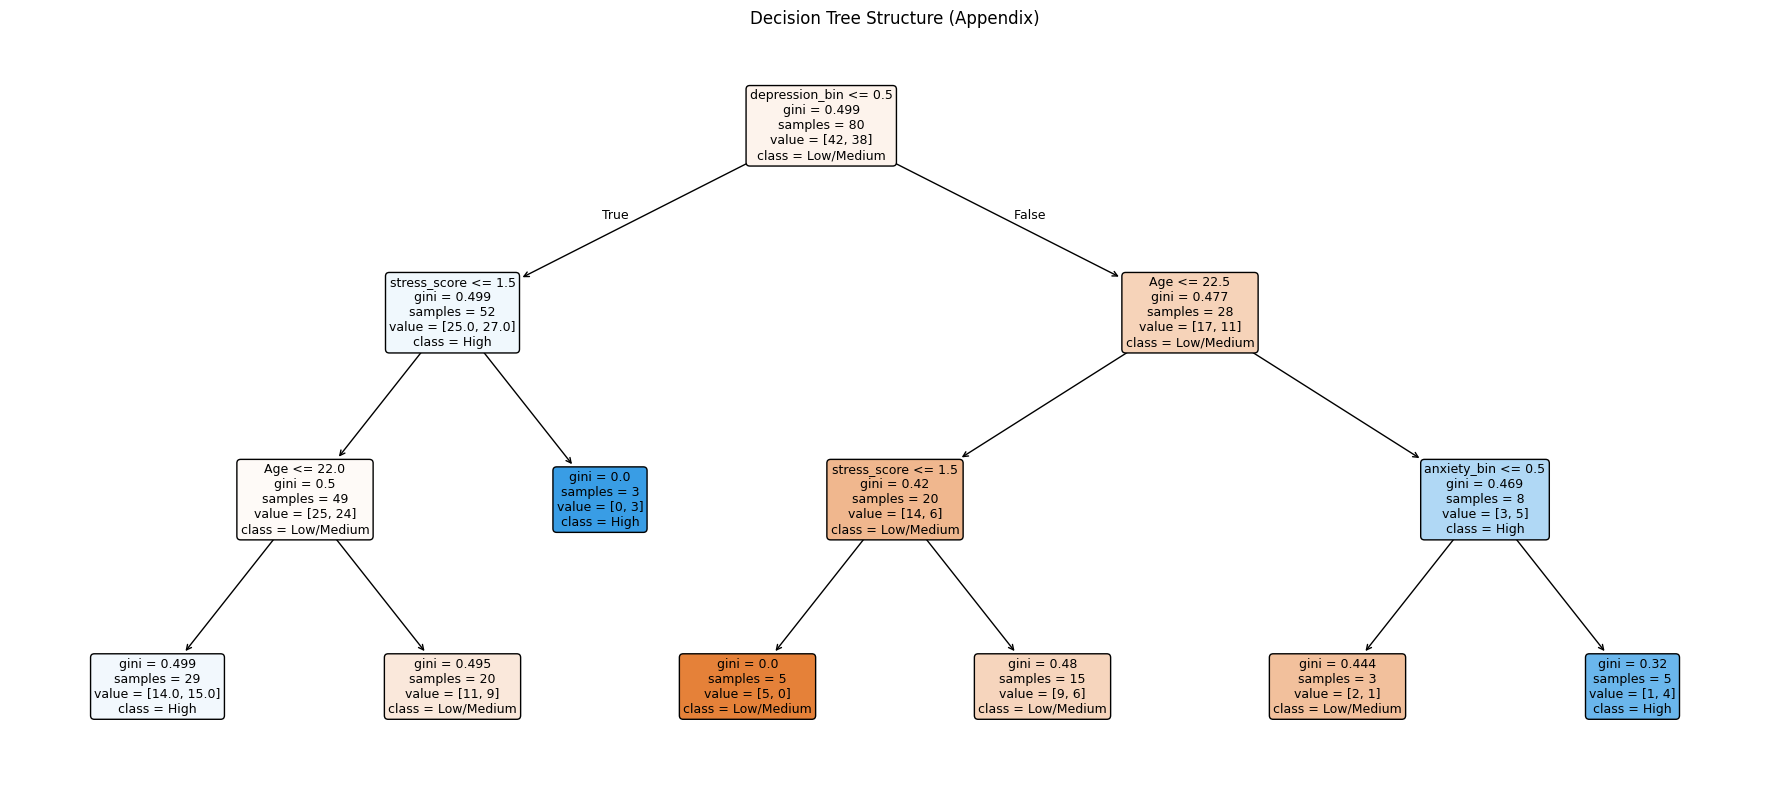

In [159]:
# ============================================================
# APPENDIX: DECISION TREE STRUCTURE VISUALIZATION
# Amaç:
# - Eğitilen Decision Tree modelinin yapısını görselleştirmek
# ============================================================

import os
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# figures klasörü yoksa oluştur
os.makedirs("figures", exist_ok=True)

# Pipeline içindeki Decision Tree modelini al
dt_model = dt_pipeline.named_steps["dt"]

plt.figure(figsize=(18, 8))
plot_tree(
    dt_model,
    feature_names=feature_cols,
    class_names=["Low/Medium", "High"],
    filled=True,
    rounded=True,
    fontsize=9
)

plt.title("Decision Tree Structure (Appendix)")
plt.tight_layout()
plt.savefig("figures/appendix_decision_tree.png", dpi=300)
plt.show()


=== Bernoulli Naive Bayes Results ===
Accuracy : 0.5714
Precision: 0.5714
Recall   : 0.4000
F1-score : 0.4706

Confusion Matrix:
[[8 3]
 [6 4]]

Classification Report:
              precision    recall  f1-score   support

           0     0.5714    0.7273    0.6400        11
           1     0.5714    0.4000    0.4706        10

    accuracy                         0.5714        21
   macro avg     0.5714    0.5636    0.5553        21
weighted avg     0.5714    0.5714    0.5593        21



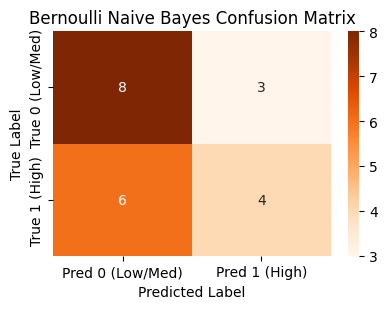

In [160]:
# ============================================================
# BLOK 12: NAIVE BAYES CLASSIFIER (BERNOULLI NB)
# Amaç:
# - Bernoulli Naive Bayes ile high_cgpa tahmini yapmak
# - Metrikleri ve Confusion Matrix'i raporlanabilir şekilde üretmek
# Not:
# - BernoulliNB ikili/0-1 özelliklerle iyi çalışır.
# - Bu veri setinde çoğu özellik binary, Age için MinMaxScaler kullanıyoruz.
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# ------------------------------------------------------------
# 1) Feature set ve target
# ------------------------------------------------------------
feature_cols = ["Age", "stress_score", "depression_bin", "anxiety_bin", "panic_bin"]
X = df[feature_cols]
y = df["high_cgpa"]

# ------------------------------------------------------------
# 2) Train/Test split (stratified)
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# ------------------------------------------------------------
# 3) Pipeline: imputer -> minmax scaler -> BernoulliNB
# ------------------------------------------------------------
nb_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler()),     # Age ve stress_score'ı [0,1]'e çeker
    ("nb", BernoulliNB())
])

# ------------------------------------------------------------
# 4) Model eğitimi ve tahmin
# ------------------------------------------------------------
nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_test)

# ------------------------------------------------------------
# 5) Metrikler (pos_label=1 => High CGPA sınıfı)
# ------------------------------------------------------------
acc = accuracy_score(y_test, y_pred_nb)
prec = precision_score(y_test, y_pred_nb, pos_label=1)
rec = recall_score(y_test, y_pred_nb, pos_label=1)
f1 = f1_score(y_test, y_pred_nb, pos_label=1)

print("=== Bernoulli Naive Bayes Results ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nConfusion Matrix:")
cm_nb = confusion_matrix(y_test, y_pred_nb)
print(cm_nb)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb, digits=4))

# ------------------------------------------------------------
# 6) Confusion Matrix Heatmap
# ------------------------------------------------------------
save_fig = False  # True yaparsan dosyaya kaydeder
fig_path = "figures/fig_nb_confusion_matrix.png"

plt.figure(figsize=(4.2, 3.2))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=["Pred 0 (Low/Med)", "Pred 1 (High)"],
    yticklabels=["True 0 (Low/Med)", "True 1 (High)"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Bernoulli Naive Bayes Confusion Matrix")
plt.tight_layout()

if save_fig:
    plt.savefig(fig_path, dpi=300)

plt.show()


=== k-NN Results ===
Accuracy : 0.4762
Precision: 0.4286
Recall   : 0.3000
F1-score : 0.3529

Confusion Matrix:
[[7 4]
 [7 3]]

Classification Report:
              precision    recall  f1-score   support

           0     0.5000    0.6364    0.5600        11
           1     0.4286    0.3000    0.3529        10

    accuracy                         0.4762        21
   macro avg     0.4643    0.4682    0.4565        21
weighted avg     0.4660    0.4762    0.4614        21



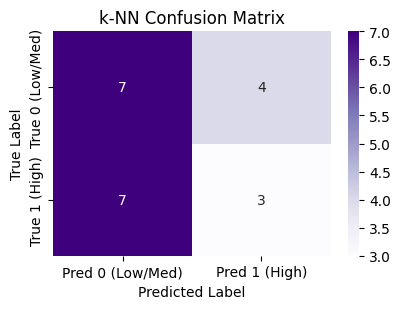

In [161]:
# ============================================================
# BLOK 13: k-NN CLASSIFIER
# Amaç:
# - kNN ile high_cgpa tahmini yapmak
# - Pipeline: imputer -> scaler -> KNN
# - Metrik + Confusion Matrix üretmek
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# 1) Feature set ve target
feature_cols = ["Age", "stress_score", "depression_bin", "anxiety_bin", "panic_bin"]
X = df[feature_cols]
y = df["high_cgpa"]

# 2) Train/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 3) Pipeline
knn_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(
        n_neighbors=5,        # istersen 3,7,9 da deneyebiliriz
        weights="distance"    # uzak olana daha az ağırlık
    ))
])

# 4) Train + Predict
knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)

# 5) Metrics
acc = accuracy_score(y_test, y_pred_knn)
prec = precision_score(y_test, y_pred_knn, pos_label=1, zero_division=0)
rec = recall_score(y_test, y_pred_knn, pos_label=1, zero_division=0)
f1 = f1_score(y_test, y_pred_knn, pos_label=1, zero_division=0)

print("=== k-NN Results ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nConfusion Matrix:")
cm_knn = confusion_matrix(y_test, y_pred_knn)
print(cm_knn)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, digits=4, zero_division=0))

# 6) Confusion Matrix Heatmap
plt.figure(figsize=(4.2, 3.2))
sns.heatmap(
    cm_knn,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=["Pred 0 (Low/Med)", "Pred 1 (High)"],
    yticklabels=["True 0 (Low/Med)", "True 1 (High)"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("k-NN Confusion Matrix")
plt.tight_layout()
plt.show()


=== Random Forest Results ===
Accuracy : 0.4762
Precision: 0.4444
Recall   : 0.4000
F1-score : 0.4211

Confusion Matrix:
[[6 5]
 [6 4]]

Classification Report:
              precision    recall  f1-score   support

           0     0.5000    0.5455    0.5217        11
           1     0.4444    0.4000    0.4211        10

    accuracy                         0.4762        21
   macro avg     0.4722    0.4727    0.4714        21
weighted avg     0.4735    0.4762    0.4738        21



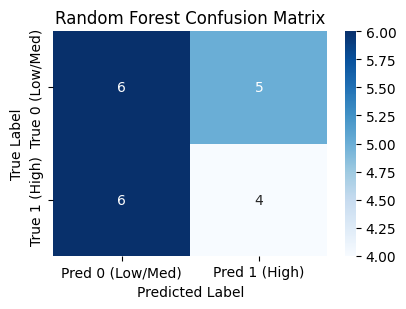


Feature Importances (Random Forest):
Age               0.557930
stress_score      0.158283
anxiety_bin       0.102121
depression_bin    0.099501
panic_bin         0.082165
dtype: float64


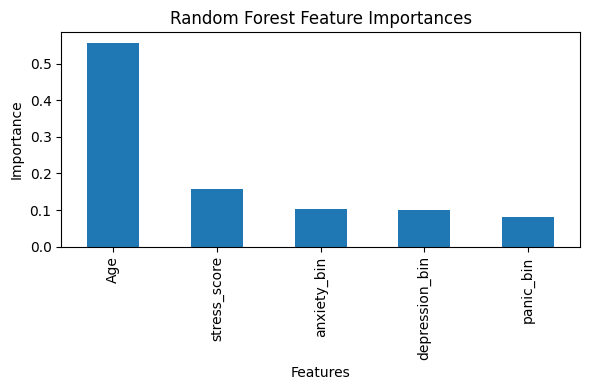

In [162]:
# ============================================================
# BLOK 14: RANDOM FOREST CLASSIFIER
# Amaç:
# - Random Forest ile high_cgpa tahmini yapmak
# - Pipeline: imputer -> RandomForest
# - Metrik + Confusion Matrix üretmek
# - Ek: Feature importance almak
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# 1) Feature set ve target
feature_cols = ["Age", "stress_score", "depression_bin", "anxiety_bin", "panic_bin"]
X = df[feature_cols]
y = df["high_cgpa"]

# 2) Train/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 3) Pipeline (RF scaling istemez)
rf_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,         # istersen 3-6 gibi sınır koyabiliriz
        random_state=42,
        class_weight="balanced",
        min_samples_split=2,
        min_samples_leaf=1
    ))
])

# 4) Train + Predict
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

# 5) Metrics
acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf, pos_label=1, zero_division=0)
rec = recall_score(y_test, y_pred_rf, pos_label=1, zero_division=0)
f1 = f1_score(y_test, y_pred_rf, pos_label=1, zero_division=0)

print("=== Random Forest Results ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, digits=4, zero_division=0))

# 6) Confusion Matrix Heatmap
plt.figure(figsize=(4.2, 3.2))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0 (Low/Med)", "Pred 1 (High)"],
    yticklabels=["True 0 (Low/Med)", "True 1 (High)"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

# 7) Feature importance (rapora eklemek için çok iyi)
rf_model = rf_pipeline.named_steps["rf"]
importances = pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values(ascending=False)

print("\nFeature Importances (Random Forest):")
print(importances)

plt.figure(figsize=(6,4))
importances.plot(kind="bar")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


In [163]:
# ============================================================
# BLOK 15: MODEL COMPARISON TABLE
# ============================================================

import pandas as pd

results = [
    {"Model": "Logistic Regression", "Accuracy": 0.6667, "Precision": 0.8000, "Recall": 0.4000, "F1": 0.5333},
    {"Model": "Decision Tree",       "Accuracy": 0.5238, "Precision": 0.5000, "Recall": 0.5000, "F1": 0.5000},
    {"Model": "Naive Bayes",         "Accuracy": 0.5714, "Precision": 0.5714, "Recall": 0.4000, "F1": 0.4706},
]

# kNN ve RF sonuçlarını da çalıştırınca buraya eklersin:
# results.append({"Model":"kNN", "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1})
# results.append({"Model":"Random Forest", "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1})

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision  Recall      F1
0  Logistic Regression    0.6667     0.8000     0.4  0.5333
1        Decision Tree    0.5238     0.5000     0.5  0.5000
2          Naive Bayes    0.5714     0.5714     0.4  0.4706


In [164]:
import joblib

# Model kaydet
joblib.dump(logreg_pipeline, "/content/drive/MyDrive/Student-Stress-Academic-Performance/models/logreg_pipeline.joblib")

# Feature list kaydet (ileride gerekebilir)
joblib.dump(feature_cols, "/content/drive/MyDrive/Student-Stress-Academic-Performance/models/feature_cols.joblib")

# Aynı split ile değerlendirme yapabilmek için test setini de kaydet
split_pack = {
    "X_test": X_test,
    "y_test": y_test,
    "X_train": X_train,
    "y_train": y_train
}
joblib.dump(split_pack, "/content/drive/MyDrive/Student-Stress-Academic-Performance/models/split_pack.joblib")

print("Saved:")
print("/content/drive/MyDrive/Student-Stress-Academic-Performance/models/logreg_pipeline.joblib")
print("/content/drive/MyDrive/Student-Stress-Academic-Performance/models/feature_cols.joblib")
print("/content/drive/MyDrive/Student-Stress-Academic-Performance/models/split_pack.joblib")


Saved:
/content/drive/MyDrive/Student-Stress-Academic-Performance/models/logreg_pipeline.joblib
/content/drive/MyDrive/Student-Stress-Academic-Performance/models/feature_cols.joblib
/content/drive/MyDrive/Student-Stress-Academic-Performance/models/split_pack.joblib
